<a href="https://colab.research.google.com/github/GeoLinkCoding/EarthResources_DataScience/blob/main/Classification/Notebooks/Classification_FirstPass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Classification First Pass

### Introduction

This project will seek to use supervised classification techniques for fault detection with geospatial imagery. 10 rasters will be used as X data with a binary raster of fault lines as the labeled data. Training data is of an extent roughly 60x60 km north east of Reno, NV in the United States. It will be split into training and test sets to measure model performance. Higher performing models will be applied to a dataset, without labeled data, with an extent of about 45x45 km directly north of the Vatnajökull glacier in Iceland, where the Askja Caldera/Lake resides. This area has undergone major tectonic and volcanic activity, with a major eruptive event in 1875.

X-data imagery will consist of Landsat bands 2-7 (rgb, near infrared, and 2 short-wave infrared bands), a digital elevation model (DEM), clay minerals ratio (CMI) derived from from bands 6 and 7, and aspect and slope derived from the DEM. The Nevada DEM was retrieved from the US environmental protection agency (EPA) web archive. The Iceland DEM was retrieved from the University of Minnesota's FRIDGE datahub. The fault raster was created from US fault data retrieved from Esri's Living Atlas.

### Preprocessing

A detailed guide of preprocessing steps and further exploratory data analysis can be accessed on the "Classification_EDA" notebook within this repository, a must read if you don't have intuitive understanding of geospatial imagery. Regardless, here is a summary of steps taken: loaded data from GitHub repository, clipped landsat layers and handled nodata values, created CMI, resampled, clipped, and handled nodata values for DEM and fault raster, and finally, created slope and aspect.

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 35.9 MB/s eta 0:00:00


In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import gc
from rasterio.warp import reproject, Resampling
import requests
import os
import pandas as pd
import glob

repo_api_url = "https://api.github.com/repos/GeoLinkCoding/EarthResources_DataScience/contents/Classification/Data"
response = requests.get(repo_api_url).json()

# Extract filenames
files = [file["download_url"] for file in response if file["type"] == "file"]
for file in files:
    os.system(f"wget {file}")

raster_files = glob.glob("N*")
raster_files.sort()
print(raster_files)

['NevadaB2.tif', 'NevadaB3.tif', 'NevadaB4.tif', 'NevadaB5.tif', 'NevadaB6.tif', 'NevadaB7.tif', 'NevadaDEM.tif', 'NevadaFault.tif']


Landsat bands shape: (11, 2000, 2000)


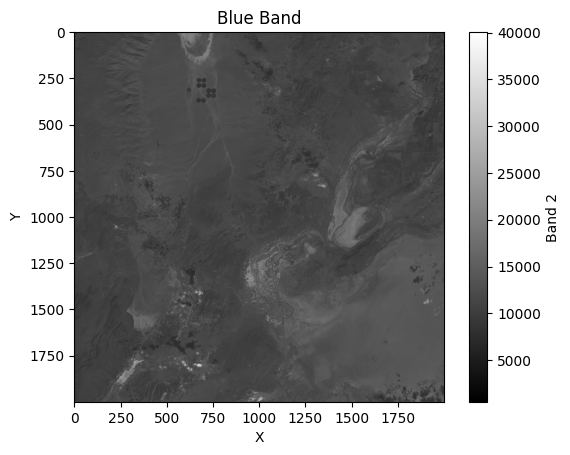

In [3]:
imgs = np.empty((11,2000,2000))
for i in range(6):
    with rasterio.open(raster_files[i]) as src:
        nodata_value = src.nodata
        window = rasterio.windows.Window.from_slices((1000,3000),(1000,3000))
        img = src.read(1, window=window)
        imgs[i,:,:] = np.where(img == src.nodata, np.nan, img)

b6 = imgs[4,:,:]
b7 = imgs[5,:,:]
# Calculate the new raster (B6 / B7)
# Replace 0 values in b6 to avoid division by zero  # Replace with NaN or a small value
CMI = np.divide(b6, b7, out=np.zeros_like(b6, dtype=float), where=b7 != 0)
imgs[6,:,:] = CMI

print(f'Landsat bands shape: {imgs.shape}')
plt.imshow(imgs[0,:,:], cmap='grey')
plt.colorbar(label='Band 2')
plt.title('Blue Band')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

**Figure 1.** Landsat image of a region northeast of Reno, Nevada. Band 2, which ranges the electromagnetic spectrum corresponding to blue light, is displayed in grey scale.

In [4]:
reference_band = raster_files[0]
with rasterio.open(reference_band) as ref:
    ref_transform = ref.transform
    ref_crs = ref.crs
    ref_width = ref.width
    ref_height = ref.height

dem = raster_files[6]
with rasterio.open(dem) as src:
    nodata_value = src.nodata
    dem_resampled = np.empty((ref_height, ref_width), dtype=np.float32)
    src.read(1, out = dem_resampled,
                        resampling=Resampling.bilinear)
    dem_clipped = dem_resampled[1000:3000, 1000:3000]
    dem_clipped = np.where(dem_clipped == nodata_value, np.nan, dem_clipped)
print(f'DEM new shape: {dem_clipped.shape}')

fault_raster = raster_files[7]
with rasterio.open(fault_raster) as src:
    nodata_value = src.nodata
    fault_resampled = np.empty((ref_height, ref_width), dtype=np.float32)
    src.read(1, out = fault_resampled,
                        resampling=Resampling.nearest)
    fault_clipped = fault_resampled[1000:3000, 1000:3000]
    fault_clipped = np.where(fault_clipped == nodata_value, np.nan, fault_clipped)
print(f'Fault new shape: {fault_clipped.shape}')
print(f'Fault pixel count: {np.sum(fault_clipped==1)}')
imgs[7,:,:] = dem_clipped
imgs[10,:,:] = fault_clipped

DEM new shape: (2000, 2000)
Fault new shape: (2000, 2000)
Fault pixel count: 15780


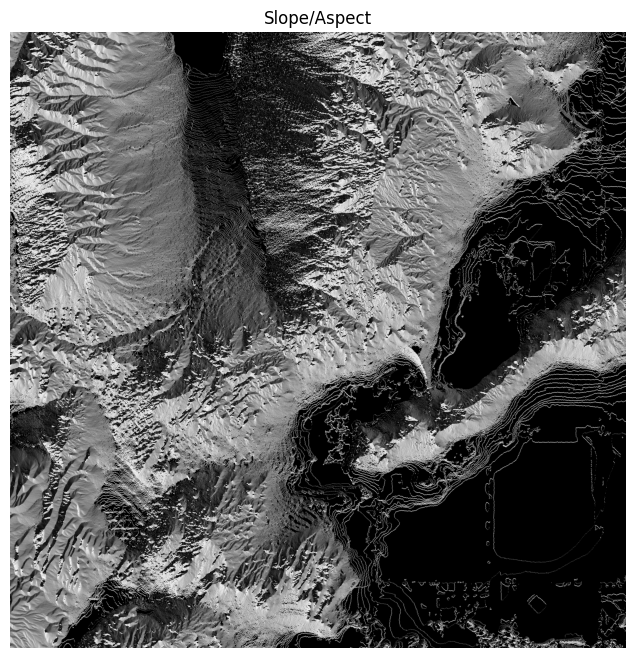

In [5]:
# Calculate resolution
x_res = 30  # Pixel width
y_res = -30  # Pixel height (negative)

# Compute gradients
gy, gx = np.gradient(imgs[7,:,:], y_res, x_res)

# Compute aspect in degrees
aspect = np.degrees(np.arctan2(gy, -gx))
slope = np.arctan(np.sqrt(gx**2 + gy**2)) * (180 / np.pi)

imgs[8,:,:] = aspect
imgs[9,:,:] = slope

slope_aspect_image = np.dstack([aspect,slope])
plt.figure(figsize=(8, 8))
plt.imshow(slope_aspect_image[:, :, 0], cmap='grey')
plt.title('Slope/Aspect')
plt.axis('off')
plt.show()

**Figure 2.** Slope and Aspect, which are derived from a digital elevation model, are stacked and displayed.

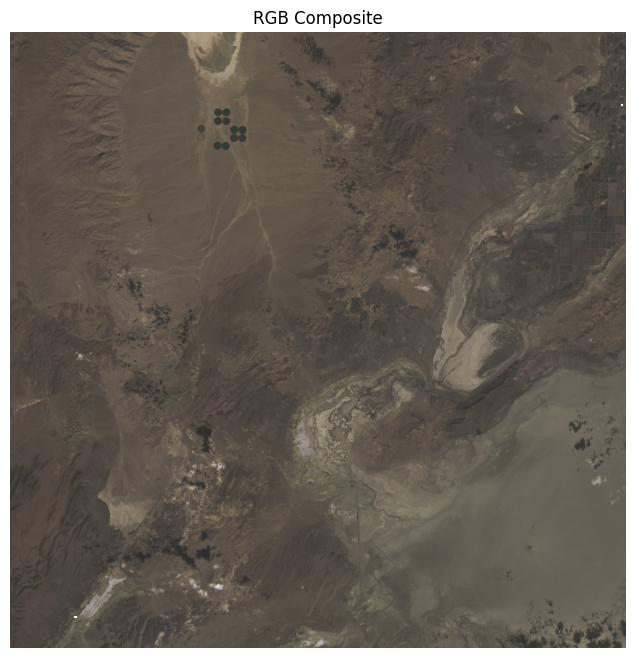

In [6]:
rgb_bands = [imgs[2, :, :], imgs[1, :, :], imgs[0, :, :]]

rgb_image = np.dstack(rgb_bands)
rgb_norm = (rgb_image - np.nanmin(rgb_image)) / (np.nanmax(rgb_image) - np.nanmin(rgb_image))
# Plot the RGB image
plt.figure(figsize=(8, 8))  # Adjust figure size if needed
plt.imshow(rgb_norm)
plt.title('RGB Composite')
plt.axis('off')  # Optional: Turn off axes
plt.show()

**Figure 3.** Red, green, and blue bands are stacked as a 3 color composite to show the visible light spectrum which a human would see from the same angle.

### Imported Libraries

In [7]:
!pip install CheckmateSample --upgrade

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xarray as xr
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Splitting Data

Due to spatial autocorrelation, data cannot be randomly split into training and testing datasets. This would cause the model to catch a glimpse of the test data when training since each data point is not independent from it's neighbors. We'll use a checkerboard method to split the data into training and testing. Both datasets will be flattened and nan values will be removed.

In [9]:
def make_checkerboard(board_size, square_size):
    rows, cols = board_size
    sq_rows, sq_cols = square_size
    row_indices = np.arange(rows) // sq_rows
    col_indices = np.arange(cols) // sq_cols
    checkerboard = (row_indices[:, np.newaxis] + col_indices) % 2
    return checkerboard.astype('float32')

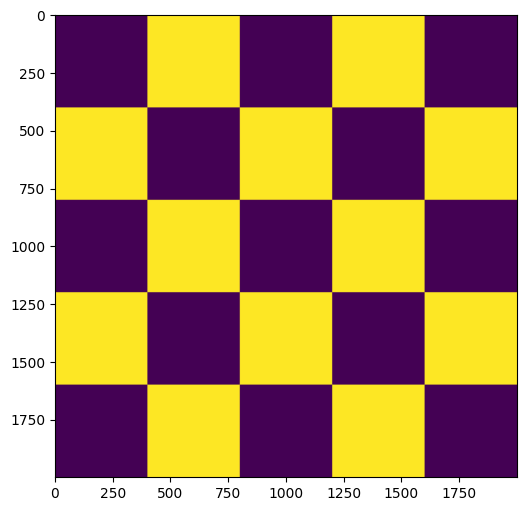

In [10]:
checker = make_checkerboard(imgs[0,:,:].shape,(400,400))
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(checker)
plt.show()

**Figure 4.** A 5x5 checkerboard over the same extent as the Nevada dataset. Purple squares will define the training data while the yellow will define the test data. This helps prevent data leakage into the training model.

In [11]:
X_data = imgs[0:10,:,:].copy()
y_data = imgs[10,:,:].copy()
X_flat = X_data.reshape(X_data.shape[0], -1).T
y_flat = y_data.flatten()

X_check0 = X_flat[checker.flatten() == 0]
y_check0 = y_flat[checker.flatten() == 0]

X_check1 = X_flat[checker.flatten() == 1]
y_check1 = y_flat[checker.flatten() == 1]

check0_combined = np.column_stack((X_check0, y_check0))
check1_combined = np.column_stack((X_check1, y_check1))

nan_indices_check0 = np.isnan(check0_combined).any(axis=1)
nan_indices_check1 = np.isnan(check1_combined).any(axis=1)

check0_filtered = check0_combined[~nan_indices_check0]
check1_filtered = check1_combined[~nan_indices_check1]

X_train = check0_filtered[:, :-1]
y_train = check0_filtered[:, -1]

X_test = check1_filtered[:, :-1]
y_test = check1_filtered[:, -1]

print(f'Training X,y shape: {X_train.shape}, {y_train.shape}')
print(f'Testing X,y shape: {X_test.shape}, {y_test.shape}')

Training X,y shape: (2079978, 10), (2079978,)
Testing X,y shape: (1920000, 10), (1920000,)


### Feature Scaling and Resampling

Scaling combats model bias to large values. Standardization and normalization were initially tested and found to have similar results but normalization was ultimately chosen due to slightly better performance.

Because the quanity of pixels classified as faults is far outclassed by the quantity of no fault pixels, resampling is necesarry to scale the training dataset. Training data will be randomly under sampled to output an almost equal quantity of both classes.

In [12]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)  # Adjust sampling_strategy if needed
X_train, y_train = undersampler.fit_resample(X_train, y_train)


In [13]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Normalized training X shape: {X_train_scaled.shape}')

Normalized training X shape: (14204, 10)


### Classifiers

Classification models will be scored by five metrics. The first three are recall, precision, and f1. Recall measures how many true positives were correctly identified for a particular probablity threshold. Precision works very similar but instead measures how often true negatives are predicted. F1 combines the score from both. The last two are roc curve and auc. Roc curve displays the true positive vs false positive rate, where auc is the area under the curve.

Different projects will require more well tuned recall or precision based on the desired output, though both are still desired to be high for all projects. In this project we care mostly about finding faults so recall will be the more important metric.

In [14]:
def evaluate_model(model, X_test, y_test, model_name):
    y_prob = model.predict_proba(X_test)[:, 1]
    thresholds = [0.1,0.2,0.3,0.4,0.5]

    recalls = []
    precisions = []
    f1s = []

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)

        print(f"Threshold: {threshold:.1f}")
        print(f"  Recall, Precision, F1-Score: {recall:.4f}, {precision:.4f}, {f1:.4f}")
        print("")

   # Plot metrics vs. thresholds
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.bar(thresholds, recalls, width=0.05, label='Recall')
    plt.xlabel('Probability Threshold')
    plt.ylabel('Recall')
    plt.title(f'Recall vs. Thresholds ({model_name})')
    plt.xticks(thresholds)
    plt.legend()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({model_name})')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Logistic Regression

Logistic Regression is specifically used for binary classification. It assigns labels based on probability where >50% is 1 and <50% is 0, but this can be changed.

Threshold: 0.1
  Recall, Precision, F1-Score: 1.0000, 0.0047, 0.0093

Threshold: 0.2
  Recall, Precision, F1-Score: 0.9980, 0.0048, 0.0095

Threshold: 0.3
  Recall, Precision, F1-Score: 0.9814, 0.0052, 0.0104

Threshold: 0.4
  Recall, Precision, F1-Score: 0.8569, 0.0060, 0.0119

Threshold: 0.5
  Recall, Precision, F1-Score: 0.4593, 0.0066, 0.0131



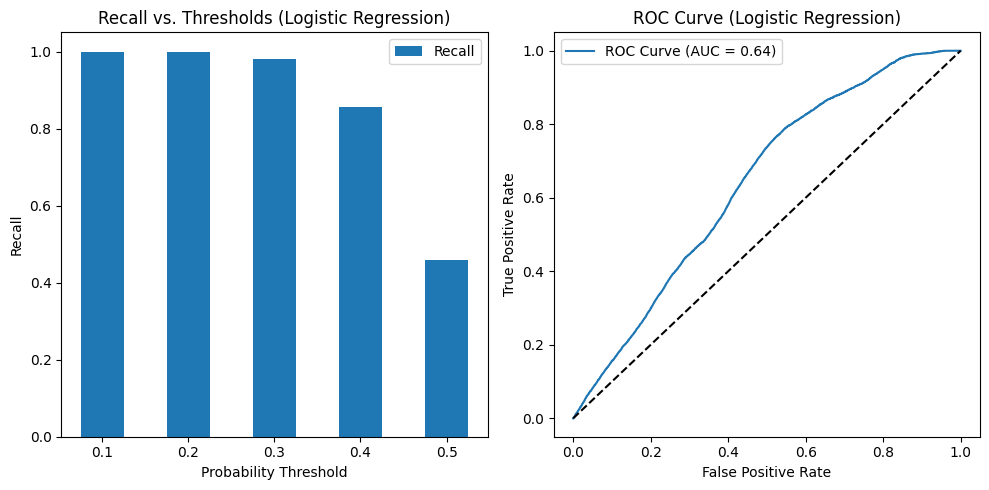

In [15]:
model_lr = LogisticRegression()
model_lr.fit(X_train_scaled, y_train)
evaluate_model(model_lr, X_test_scaled, y_test, 'Logistic Regression')

**Figure 5.** With lower probability thresholds, recall became increasingly accurate, however with precision being so low, there are a great many false positives too. An AUC of 62 is quite poor and borderline random.

### Decision Tree Classifier

Decision tree models split data into branches based on its features. Many trees can be combined into ensemble models like Random Forest.

Threshold: 0.1
  Recall, Precision, F1-Score: 0.4734, 0.0081, 0.0160

Threshold: 0.2
  Recall, Precision, F1-Score: 0.4734, 0.0081, 0.0160

Threshold: 0.3
  Recall, Precision, F1-Score: 0.4734, 0.0081, 0.0160

Threshold: 0.4
  Recall, Precision, F1-Score: 0.4734, 0.0081, 0.0160

Threshold: 0.5
  Recall, Precision, F1-Score: 0.4734, 0.0081, 0.0160



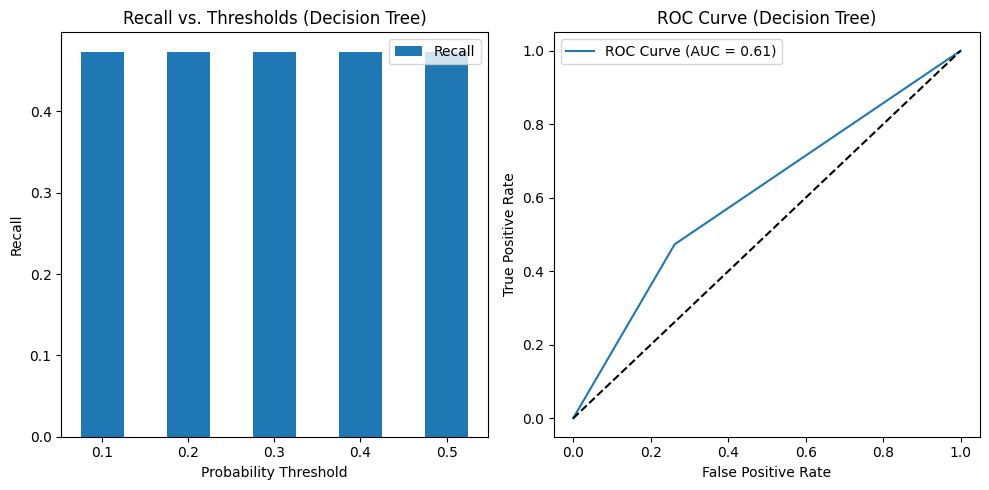

In [16]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scaled, y_train)
evaluate_model(model_dt, X_test_scaled, y_test, 'Decision Tree')

**Figure 6.** This model produces the same metrics for each probability threshold. It did more poorly on most metrics compared to Logistic Regression.

### Gradient Boosting Classifier

Gradient Boost is an ensemble method that builds decision trees and corrects errors with each new tree.

Threshold: 0.1
  Recall, Precision, F1-Score: 0.9426, 0.0059, 0.0117

Threshold: 0.2
  Recall, Precision, F1-Score: 0.8901, 0.0066, 0.0130

Threshold: 0.3
  Recall, Precision, F1-Score: 0.8638, 0.0072, 0.0143

Threshold: 0.4
  Recall, Precision, F1-Score: 0.8145, 0.0077, 0.0153

Threshold: 0.5
  Recall, Precision, F1-Score: 0.6658, 0.0080, 0.0158



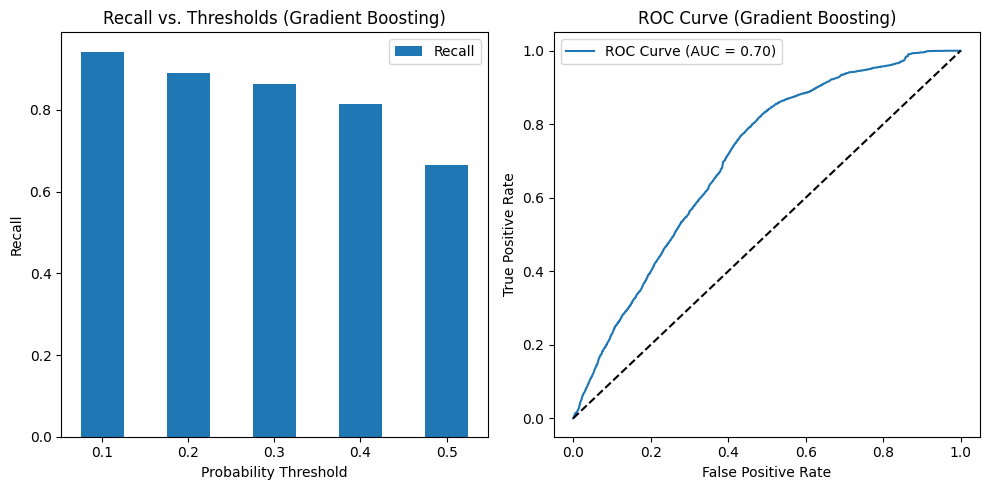

In [17]:
model_gbc = GradientBoostingClassifier()
model_gbc.fit(X_train_scaled, y_train)
evaluate_model(model_gbc, X_test_scaled, y_test, 'Gradient Boosting')

**Figure 7.** Our ROC and AUC metrics were better than Logistic Regression but the others were fairly similar. There's a higher recall as probability threshold decreases, but precision and f1 are still very low.

In [18]:
def get_proba_mask(X_data, model, scaler):
    nodata_mask = np.any(np.isnan(X_data),axis=0)
    X = X_data[:,~nodata_mask]
    X = X.reshape(X.shape[0], -1).T
    X_scaled = scaler.transform(X)

    predictions = model.predict_proba(X_scaled)[:, 1]
    pred_ar = np.zeros(shape=nodata_mask.flatten().shape, dtype='float32')
    pred_ar[np.invert(nodata_mask.flatten())] = predictions
    pred_ar = pred_ar.reshape(nodata_mask.shape)
    pred_ar[nodata_mask] = np.nan
    return pred_ar

### Probability Mapping

It's clear that the models are performing quite poorly and would not be useful in applying to a new dataset as a direct classifier. However, there is potential for these models to help locate faults through probability mapping. Probability mapping evaluates the probability of each pixel being a fault and displays the raster as a gradient with higher probabilities indicating more likelihood of a fault being around that location.

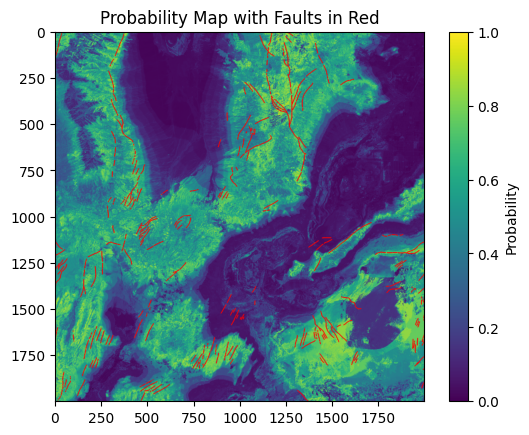

In [21]:
from scipy.ndimage import binary_dilation
pred_gbc = get_proba_mask(X_data, model_gbc, scaler)
fault_mask = (imgs[10,:,:] == 1)
fault_mask = binary_dilation(fault_mask, iterations=2)
probability_rgb = plt.cm.viridis(pred_gbc)
probability_rgb[..., :3][fault_mask] = [1, 0, 0]
probability_rgb[..., 3] = 1
plt.imshow(probability_rgb)
plt.colorbar(label="Probability")
plt.title("Probability Map with Faults in Red")
plt.show()

**Figure 8.** The red lines are an overlay of the true fault data. Generally they fall around the high probability zones but in some areas they are in low probability. We also see some high probability zones with no fault data. However, the probability map does display the terrain quite well so there is some correct pattern being learned.

### Application (Iceland)

We'll hold off on this for now until we have better performing models in the final pass.

### Analysis Review

**Which method did you like the most?**

Gradient Boost was my favorite method. Due to its ensemble approach, it can handle more complexity from the data. It performed about the same as Logistic Regression but just slightly higher in most metrics.

**Which method did you like the least?**

Decision Trees was my least favorite approach. It performed slightly worse than Logistic Regression and had no probability differentiating. It is better suited as a base algorithm for ensemble methods that deploy multiple to build off each other.

**How did you score these supervised models?**

I scored these models using recall, precision, f1, roc curve, and auc. Accuracy has no application in this project due to the heavy imbalance between classes and most models would likely report very high accuracy.

**Did the output align with your geologic understanding?**

The output so far has been poor but this does shed some light on the data and its relatability to fault detection. Surface faults are generally only a few meters in width, however, the raster cell size used here is 30 meters, which could explain the lower scores. Sentinel data at 10 meter resolution with higher resolution DEMs would likely provide better results.

**Did you hyperparameter tune? Why or why not?**

Most tuning went into data preprocessing steps like splitting, resampling, and scaling. However, different probability thresholds were tested for specific scoring metrics.

**How did you split your data? and why does that make sense for this dataset?**

Data was split by checkerboarding, where one set of grids were chosen to be training data and the other half was chosen as testing data. This was used because my data is geospatial imagery so breaking apart the data by grid helps prevent data leakage and keeps dependent datapoints together.

**What did you want to learn more about?**

I wanted to learn more about coding, visualizing, and analysing geospatial imagery in python, especially using multiple bands/rasters. I have plenty of experience using GIS software, however, python allows more fine tuning of analysis models especially in machine and deep learning.

**Did you pre-process your data?**

My data required a lot of preprocessing, some of it was done using GIS software for convenience and time saving reasons, but others were done in this notebook. Preprocessing was done in two ways, first was combining multiple datasets into one while manipulating them to be compatible together. The other part was preparring it to be optimized for a machine learning model.

**Do all models require pre-processing?**

Yes all models require preprocessing though not for all data. Many models can handle different types or states of data. Most machine learning models, at the very least, need data in numerical form and without null values, though other types of models may not have these requirements they will have others.